# ME455 Active Learning for Robotics Homework 3
**Author**: Allen Liu

In [1]:
import os
import sys
import requests
import copy

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
# import cupy as np
import modern_robotics as mr
import scipy.stats

from typing import Literal
from PIL import Image
from io import BytesIO

In [2]:
RESULTS_DIR = os.path.join(os.getcwd(), 'Results')
IMAGE_URL = (
    "https://raw.githubusercontent.com/MurpheyLab/ME455_public/main/figs/lincoln.jpg"
)

## Problem 1

In [3]:
def image_density(s, x_grid, y_grid, density_array):
    s_x, s_y = s

    ind_x = np.argmin(np.abs(x_grid - s_x))
    ind_y = np.argmin(np.abs(y_grid - s_y))

    val = density_array[ind_x, ind_y]

    return val

In [4]:
def p1_main(
    dist: Literal["uniform", "normal", "lognormal"] = "uniform",
    num_samples: int = 5000,
):
    print(f"Sampling {dist} distribution ...")

    response = requests.get(IMAGE_URL)
    image_data = BytesIO(response.content)

    image = Image.open(image_data)

    image_array = np.array(image)
    image_array = np.flipud(image_array)

    x_grids = np.linspace(0.0, 1.0, image_array.shape[0])
    y_grids = np.linspace(0.0, 1.0, image_array.shape[1])

    dx = x_grids[1]
    dy = y_grids[1]

    density_array = 255.0 - image_array
    density_array /= np.sum(density_array) * dx * dy

    samples = None

    # Multivariable normal distribution
    if dist == "normal":
        var = ((0.5) / 3)
        samples = np.random.multivariate_normal(
            mean=[0.5, 0.5], cov=[[var, 0], [0, var]], size=num_samples
        )

    # Uniform Distribution
    elif dist == "uniform":
        samples = np.random.uniform(low=0.0, high=1.0, size=(num_samples, 2))

    elif dist == "log_normal":
        m_log = np.log(0.5)
        s_log = np.sqrt(np.exp(var) * (np.exp(var) - 1))
        samples = np.random.lognormal(m_log, s_log, size=(num_samples, 2))

    else:
        raise RuntimeError("Invalid Distribution Type")

    sample_weights = np.zeros(num_samples)

    for i in range(num_samples):
        s = samples[i]
        weight = image_density(s, x_grids, y_grids, density_array)
        sample_weights[i] = weight

    sample_weights /= np.max(sample_weights)

    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(
        image_array, extent=(0, 1, 0, 1), origin="lower", cmap="gray"
    )
    axs[0].set_xlim(0.0, 1.0)
    axs[0].set_ylim(0.0, 1.0)
    axs[0].set_title("Probability Density Function")

    for s, w in zip(samples, sample_weights):
        axs[1].plot(
            s[1], s[0], linestyle="", marker="o", markersize=2, color="k", alpha=w
        )

    axs[1].set_xlim(0.0, 1.0)
    axs[1].set_ylim(0.0, 1.0)
    axs[1].set_aspect("equal")
    axs[1].set_title("Samples")

    plt.savefig(f"{RESULTS_DIR}/part1_{dist}.png", format="png", dpi=300)
    print("Done sampling, plot saved")

Sampling uniform distribution ...
Done sampling, plot saved
Sampling normal distribution ...
Done sampling, plot saved


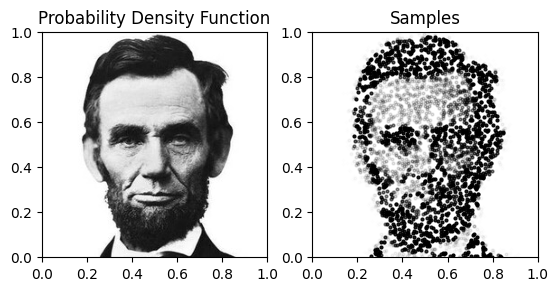

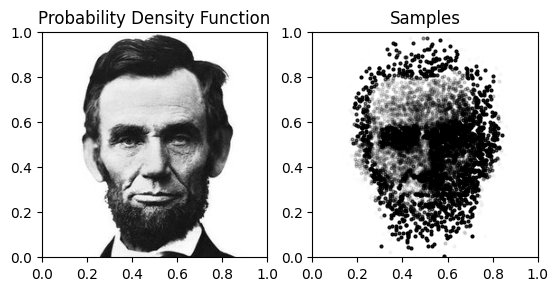

In [5]:
p1_main(dist="uniform", num_samples=5000)
p1_main(dist="normal", num_samples=5000)

## Problem 2

In [6]:
def normalize(angle):
    return np.arctan2(np.sin(angle), np.cos(angle))


def func_qdot(state, u):
    # print(state)
    theta = state[2]

    u1 = u[0]
    u2 = u[1]

    xdot = u1 * np.cos(theta)
    ydot = u1 * np.sin(theta)
    thetadot = u2
    
    # print("qdot: ", theta, u1, u2)

    qdot = np.array([xdot, ydot, thetadot])
    # qdot = np.random.multivariate_normal(qdot, np.eye(3) * noice)
    return qdot


def new_state(state, u, dt, noice=0, control_noice=0):
    u_noice = np.random.multivariate_normal(mean=u, cov=np.eye(2) * control_noice)

    st = copy.deepcopy(state)
    s1 = dt * func_qdot(st, u_noice)
    s2 = dt * func_qdot(st + s1 / 2, u_noice)
    s3 = dt * func_qdot(st + s2 / 2, u_noice)
    s4 = dt * func_qdot(st + s3, u_noice)

    state_new = st + 1.0 / 6.0 * (s1 + 2.0 * s2 + 2.0 * s3 + s4)
    state_new[:3] = np.random.multivariate_normal(
        mean=state_new[:3], cov=np.eye(3) * noice
    )
    state_new[2] = normalize(state_new[2])
    return state_new


def get_measurement(sample, noice=0):
    mean = sample[:3]
    cov = np.eye(3) * noice
    # print(sample, cov)
    return np.random.multivariate_normal(mean=mean, cov=cov)


def prob_density(z_vec, sample, noice):
    # print(sample, z_vec)
    dist = scipy.stats.multivariate_normal(mean=sample[:3], cov=np.eye(3) * noice)
    density = dist.pdf(x=z_vec)

    return density

In [7]:
def update_plot(
    frame,
    ax,
    traj,
    particles,
    noice,
    colors,
):
    ax.cla()
    ax.set_xlim(-1.0, 5.0)
    ax.set_ylim(-1.0, 3.0)

    (line,) = ax.plot(
        traj[0, : (frame + 1)],
        traj[1, : (frame + 1)],
        linewidth=7,
        color="k",
    )

    for i in range(frame + 1):
        ax.scatter(
            particles[0, :, i].flatten(),
            particles[1, :, i].flatten(),
            color=colors[i],
            edgecolors="k",
            s=20,
        )

    return (line,)


In [8]:
def p2_main(
    start: tuple[float, float, float] = (0.0, 0.0, np.pi / 2.0),
    u: tuple[float, float] = (1.0, -1.0 / 2.0),
    T: float = 2.0 * np.pi,
    dt: float = 0.1,
    noice: float = 0.02,
    num_particles: int = 10,
):

    t_list = np.arange(start=0.0, stop=T, step=dt)
    num_steps = len(t_list)

    traj = np.zeros(shape=(3, num_steps))
    particles = np.zeros(shape=(4, num_particles, num_steps))

    Sigma_mat = np.eye(3) * noice
    part_curr = np.random.multivariate_normal(
        mean=start, cov=Sigma_mat, size=num_particles
    )
    part_curr = np.c_[part_curr, np.ones(shape=(num_particles, 1)) * 1 / num_particles]

    state = copy.deepcopy(np.array(start))
    traj[:, 0] = state
    particles[:, :, 0] = part_curr.T
    sum_cum = 0

    indices = np.arange(0, num_particles)

    print("Start simulating ...")
    for i in range(1, num_steps):

        # state = new_state(state=state, u=u, dt=dt, noice=0)
        # print(state)
        state = new_state(state=state, u=u, dt=dt, noice=noice**2)
        # print(state)
        # state = new_state(state=state, u=u, dt=dt, control_noice=noice)
        z_vec = get_measurement(sample=state, noice=noice)

        for j in range(num_particles):
            s = part_curr[j, :]
            z_hat = get_measurement(sample=s)
            w = prob_density(
                z_vec=z_vec,
                sample=s,
                noice=noice,
            )
            # print(w)

            s_new = new_state(state=s[:3].T, u=u, dt=dt, noice=noice)
            part_curr[j, :3] = s_new
            part_curr[j, 3] *= w

        sum_weight = np.sum(part_curr[:, 3])
        part_curr[:, 3] /= sum_weight

        # print(part_curr[:, 3])
        part_new = np.zeros_like(part_curr)
        ind_new = np.random.choice(a=indices, size=num_particles, p=part_curr[:, 3])

        # print(ind_new)
        for j in range(num_particles):
            ind = ind_new[j]
            part_new[j, :] = part_curr[ind, :]

        part_curr = part_new

        sum_cum += sum_weight

        particles[:, :, i] = part_curr.T
        traj[:, i] = state

    print("Plotting results ...")

    cmap_rainbow = plt.get_cmap("rainbow")
    frames = np.arange(0, num_steps)
    colors = cmap_rainbow(np.linspace(0, 1, num_steps))
    colors = [tuple(row) for row in colors]
    plot_steps = np.arange(start=0, stop=num_steps, step=10)

    plt.plot(traj[0, :], traj[1, :], linewidth=5, color="k")
    plt.xlim(left=-1.0, right=5.0)
    plt.ylim(bottom=-1.0, top=3.0)

    # for i in plot_steps:
    for i in range(num_steps):
        plt.scatter(
            particles[0, :, i].flatten(),
            particles[1, :, i].flatten(),
            color=colors[i],
            edgecolors="k",
            s=20,
        )
    plt.savefig(f"{RESULTS_DIR}/part2.png", format="png", dpi=300)

    fig, ax = plt.subplots()
    ax.set_xlim(-1.0, 5.0)
    ax.set_ylim(-1.0, 3.0)

    animate = FuncAnimation(
        fig=fig,
        func=update_plot,
        fargs=(ax, traj, particles, noice, colors),
        # fargs=(line, scatter, traj, particles, noice, colors),
        frames=frames,
        interval=dt * 1e3,
        blit=True,
    )

    # plt.show()
    animate.save(f"{RESULTS_DIR}/part2.mp4", writer="ffmpeg")
    print("Simulation saved")

Start simulating ...


Plotting results ...
Simulation saved


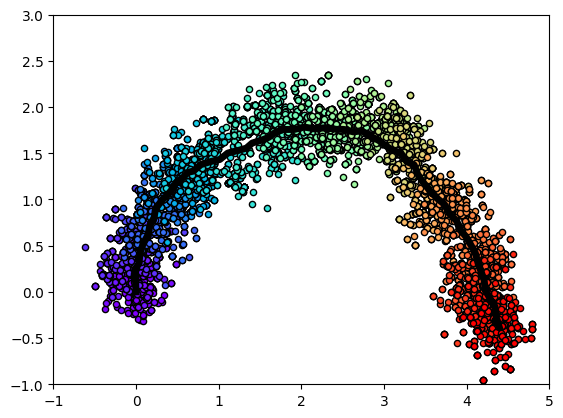

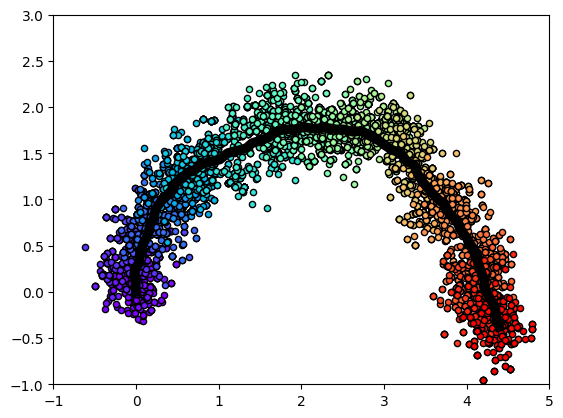

In [9]:
p2_main(
    start=(0, 0, np.pi / 2),
    u=(1.0, -1.0 / 2.0),
    T=2 * np.pi,
    dt=0.1,
    noice=0.02,
    num_particles=100,
)

# Problem 3

In [10]:
def p3_main(w1, w2, w3, mean1, mean2, mean3, cov1, cov2, cov3, num_sample):
    samples = np.zeros(shape=(num_sample, 2))
    
    weights = np.array([w1, w2, w3])
    means = np.array([mean1, mean2, mean3])
    covs = np.array([cov1, cov2, cov3])
    print(covs.shape)
    
    indeces = np.arange(3)
    
    
    
    for i in range(num_sample):
        index = np.random.choice(a=indeces, p=weights, size=1)
        
        mean = means[index, :][0]
        cov = covs[index, :, :][0]
        
        s = np.random.multivariate_normal(mean=mean, cov=cov)
        samples[i, :] = s
        
    plt.scatter(samples[:, 0], samples[:, 1])
    plt.show()
             

(3, 2, 2)


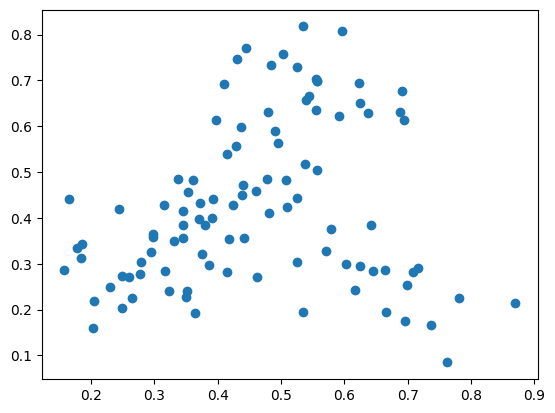

In [11]:
w1 = 0.5
w2 = 0.2
w3 = 0.3

mean1 = np.array([0.35, 0.38])
mean2 = np.array([0.68, 0.25])
mean3 = np.array([0.56, 0.64])

cov1 = np.array([[1e-2, 4e-3], [4e-3, 1e-2]])
cov2 = np.array([[5e-3, -3e-3], [-3e-3, 5e-3]])
cov3 = np.array([[8e-3, 0], [0, 8e-3]])

p3_main(w1, w2, w3, mean1, mean2, mean3, cov1, cov2, cov3, num_sample=100)